In [36]:
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from climatetranslation.unit.data import (
    get_dataset, 
    dataset_time_overlap, 
    any_calendar_to_datetime,
    construct_regridders,
    #even_lat_lon,
)

In [2]:
conf_levels = {
    0: ['pr'], 
    2:['tas', 'tasmin', 'tasmax'], 
    5500:['z500']
}

bbox = {
  'N': 75,
  'S': 30,
  'E': 40,
  'W': -30
}

In [14]:
from sklearn.linear_model import LinearRegression

def detrend(da):
    X = np.arange(len(da.time.values), dtype=float).reshape(-1, 1)
    y = da.stack(lat_lon=('lat', 'lon'))
    reg = LinearRegression().fit(X, y.values)
    return (y - reg.predict(X)).unstack()

In [3]:
def remove_daily_climatology(da, window=1):
    assert window>=1
    def identity_(x, axis=None):
        return x
    if window==1:
        climatology = da.groupby('time.dayofyear').mean()
    else:
        climatology = da.rolling(time=window).reduce(identity_).groupby('time.dayofyear').mean()
    return da.groupby('time.dayofyear') - climatology

In [4]:
from scipy import signal

def low_pass(da, cutoff=10):
    def inner(x):
        ps = 1  # Sampling period days
        w = ps / (cutoff / 2) # Normalize the frequency
        b, a = signal.butter(5, w, 'low')
        return signal.filtfilt(b, a, x)
    result = xr.apply_ufunc(
        inner, 
        da,
        input_core_dims=[['time']], 
        output_core_dims=[['time']], 
        vectorize=True
    )
    return result

In [5]:
def select_months(da, months, drop=False):
    in_months = xr.DataArray(np.isin(da['time.month'], months), coords=[da.time])
    return da.where(in_months, drop=drop)

In [6]:
def hot_summer_cold_winter(da):
    da = remove_daily_climatology(da, 1)
    da = detrend(da)
    da = low_pass(da, cutoff=10)
    da = da.mean(dim=('lat', 'lon'))
    winter = select_months(da, [12, 1, 2], drop=True)
    summer = select_months(da, [6, 7, 8], drop=True)    
    hot_summer = summer.where(summer >= summer.quantile(0.95, skipna=True, dim=('time')), drop=True)
    cold_winter = winter.where(winter <= winter.quantile(0.05, skipna=True, dim=('time')), drop=True)
    return hot_summer, cold_winter

In [7]:
def seasonal_standardise(ds):
    return ((ds.groupby('time.season') - ds.groupby('time.season').mean())
            .groupby('time.season')/ds.groupby('time.season').std())

In [107]:
def event_structures(ds):
    event_trigger_box = ds.tas.sel(
        lon=slice(-2, 20),
        lat=slice(42, 55)
    )
    hot_summer, cold_winter = hot_summer_cold_winter(event_trigger_box)
    
    # select important variables only
    ds = ds[['tas', 'z500', 'pr']]
    
    # do both absolute and relative calculations
    ds_s = seasonal_standardise(ds).expand_dims({'form':['relative']})
    ds = xr.merge([ds.expand_dims({'form':['absolute']}), ds_s])
    
    hot_sum_comp = ds.sel(time=hot_summer.time).mean(dim='time')
    cold_win_comp = ds.sel(time=cold_winter.time).mean(dim='time')
    return hot_sum_comp, cold_win_comp

### Apply to translations

In [112]:
class CompareTranslations:
    def __init__(self):
        self.cache = {}

    def event_structures(self, model, iteration, v):
        other_model = ({'era5','hadgem3'} - {model}).pop()
        ds_target = get_dataset(f"/datadrive/{model}/all_hist_zarr", 
                              conf_levels, 
                              filter_bounds=False,
                              split_at=180, 
                              bbox=bbox)
        ds_base = get_dataset(f"/datadrive/{other_model}/all_hist_zarr", 
                              conf_levels, 
                              filter_bounds=False,
                              split_at=180, 
                              bbox=bbox)
        ds_trans = get_dataset(f"/datadrive/{other_model}/to_{model}/all_hist_v{v}_{iteration}", 
                               conf_levels, 
                               filter_bounds=False, 
                               split_at=180, 
                               bbox=bbox)
        rg_t, rg_b = construct_regridders(
            ds_target, 
            ds_base, 
            resolution_match='downscale', 
            scale_method='conservative', 
            periodic=True)

        if rg_t is not None:
            ds_target = rg_t(ds_target)
        if rg_b is not None:
            ds_base = rg_b(ds_base)

        ds_target = even_lat_lon(ds_target).astype(np.float32)
        ds_base = even_lat_lon(ds_base).astype(np.float32)
        ds_trans = even_lat_lon(ds_trans).astype(np.float32)
    
        ds_target, ds_base, ds_trans = dataset_time_overlap([ds_target, ds_base, ds_trans])
        
        def get_or_compute(model, iteration, v, ds):
            if model in ['era5', 'hadgem3']:
                iteration = 'none'
                v = 'none'
            if (model, iteration, v) in self.cache.keys():
                hsc, cwc = self.cache[(model, iteration, v)]
            else:
                ds.tas.load()
                hsc, cwc = event_structures(ds.isel(run=0))
                with ProgressBar(dt=10):
                    hsc = hsc.compute()
                    cwc = cwc.compute()
                self.cache[(model, iteration, v)] = (hsc, cwc)
            return hsc, cwc
        
        hsc_targ, cwc_targ = get_or_compute(model, iteration, v, ds_target)
        hsc_trans, cwc_trans = get_or_compute(f"{other_model}_to_{model}", iteration, v, ds_trans)
        hsc_base, cwc_base = get_or_compute(other_model, iteration, v, ds_base)

        return hsc_targ, cwc_targ, hsc_trans, cwc_trans, hsc_base, cwc_base
    
# set up cache and function
comp = CompareTranslations()
compare_event_structures_translation = comp.event_structures

In [116]:
import cartopy.crs as ccrs
from skimage.metrics import structural_similarity as ssim

def common_min_max(das):
    vmin = min([da.min() for da in das])
    vmax = max([da.max() for da in das])
    return vmin, vmax

def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin).values

def add_ssim_mae(x1, x2, ax, data_range=None):
    s = ssim(x1, x2, data_range=data_range)
    mae = np.abs(x1 - x2).mean()
    ax.text(0.5, -0.1, 
            f'SSIM: {s:.3f} | MAE: {mae:.3f}', 
            ha='center', 
            va='center', 
            transform=ax.transAxes)

def plot_row(events_das, axes, form):
    vmin, vmax = common_min_max(events_das)
    if form=='relative':
        vmax = max([-vmin, vmax])
        vmin = -vmax
    data_range = calc_range(events_das)
    for e_da, ax in zip(events_das, axes):
        e_da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        add_ssim_mae(e_da.values, events_das[0].values, ax, data_range=data_range)

def compare_events(event_target, event_trans, event_base, target_model=None, form='relative'):
    plt.figure(figsize=(12, 8))
    axes = [plt.subplot(331+i, projection=ccrs.PlateCarree()) for i in range(9)]
    events = [e.sel(form=form) for e in [event_target, event_trans, event_base]]
    
    plot_row([e.tas for e in events], axes[0:3], form)
    plot_row([e.z500 for e in events], axes[3:6], form)
    plot_row([e.pr for e in events], axes[6:9], form) 
    
    if target_model is None:
        titles = ['target', 'translation', 'base']
    else:
        other_model = ({'era5','hadgem3'} - {target_model}).pop()
        titles = [target_model, f"{other_model} to {target_model}", other_model]
    for ax, title in zip(axes[:3], titles):
        ax.set_title(title)
    for ax in axes[3:]:
        ax.set_title('')
    for ax in axes: ax.coastlines(alpha=0.5)

#### V3 at iteration 30,000 ERA5 -> HadGEM

In [114]:
v3_e2h_events_30k = compare_event_structures_translation('hadgem3', 30000, 3)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)
[########################################] | 100% Completed | 30.0s
[########################################] | 100% Completed | 30.0s
[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed | 30.1s


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed | 30.0s


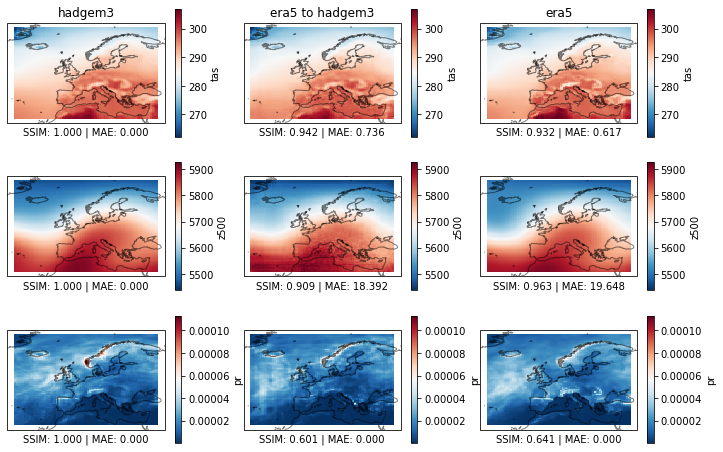

In [118]:
# summer events
compare_events(*v3_e2h_events_30k[0::2], 'hadgem3', form='absolute')
plt.show()

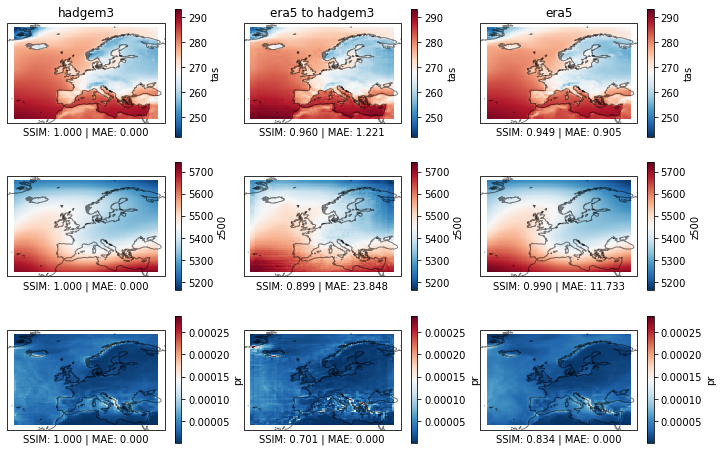

In [119]:
# winter events
compare_events(*v3_e2h_events_30k[1::2], 'hadgem3', form='absolute')
plt.show()

#### V3 at iteration 30,000 HadGEM -> ERA5

In [121]:
v3_h2e_events_30k = compare_event_structures_translation('era5', 30000, 3)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)


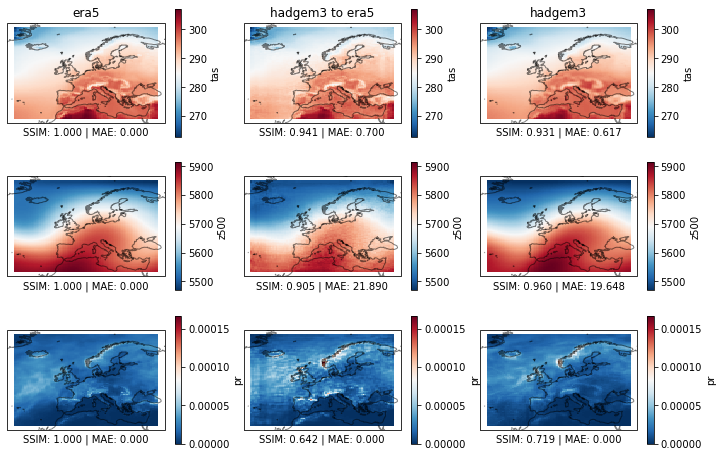

In [122]:
# summer events
compare_events(*v3_h2e_events_30k[0::2], 'era5', form='absolute')
plt.show()

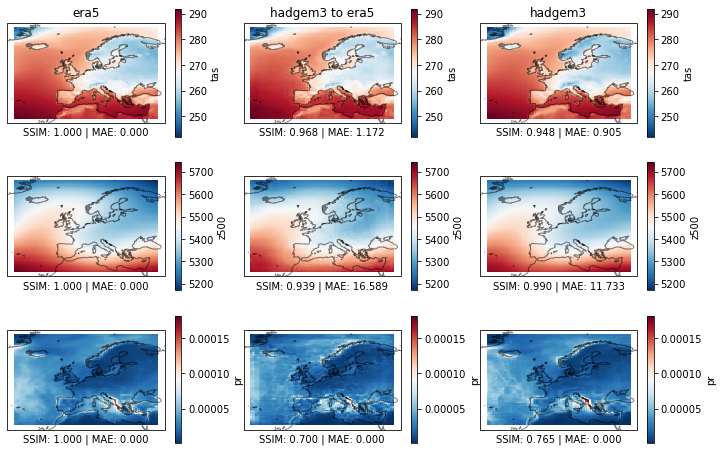

In [123]:
# winter events
compare_events(*v3_h2e_events_30k[1::2], 'era5', form='absolute')
plt.show()

#### V3 at iteration 300,000 HadGEM -> ERA5

In [73]:
v3_h2e_events_300k = compare_event_structures_translation('era5', 300_000, 3)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s


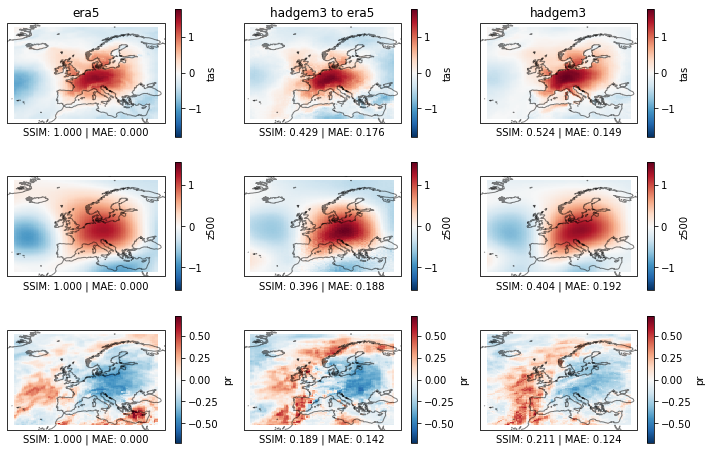

In [94]:
# summer events
compare_events(*v3_h2e_events_300k[0::2], 'era5')
plt.show()

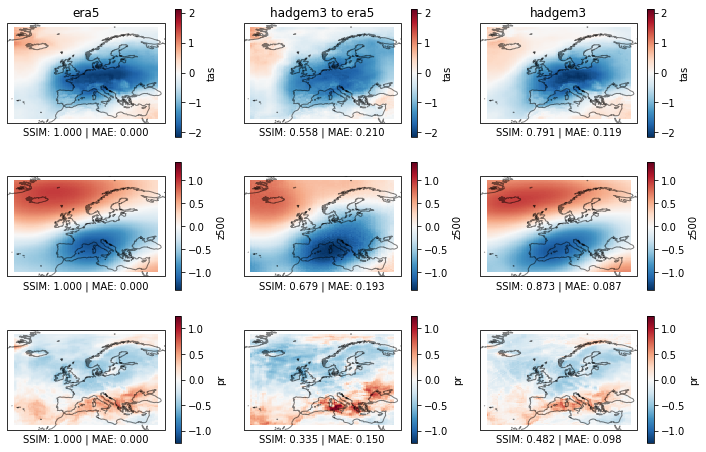

In [93]:
# winter events
compare_events(*v3_h2e_events_300k[1::2], 'era5')
plt.show()

#### V2 at iteration 30,000 HadGEM -> ERA5

In [84]:
v2_h2e_events_30k = compare_event_structures_translation('era5', 30_000, 2)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s


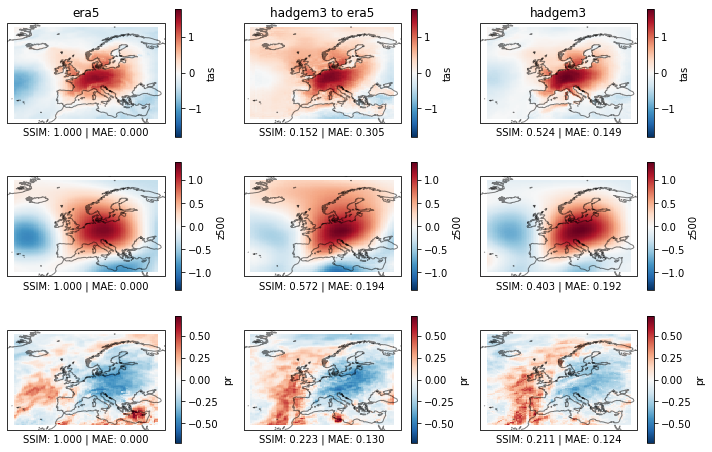

In [90]:
# summer events
compare_events(*v2_h2e_events_30k[0::2], 'era5')
plt.show()

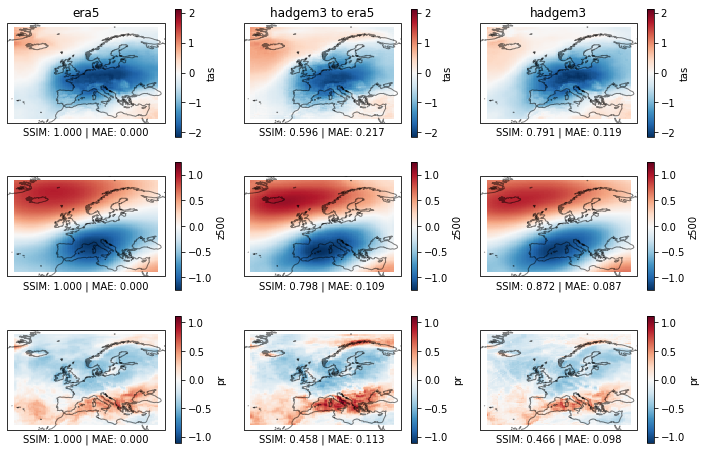

In [91]:
# winter events
compare_events(*v2_h2e_events_30k[1::2], 'era5')
plt.show()

#### V2 at iteration 300,000 HadGEM -> ERA5

In [99]:
v2_h2e_events_300k = compare_event_structures_translation('era5', 300_000, 2)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.1s


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.0s


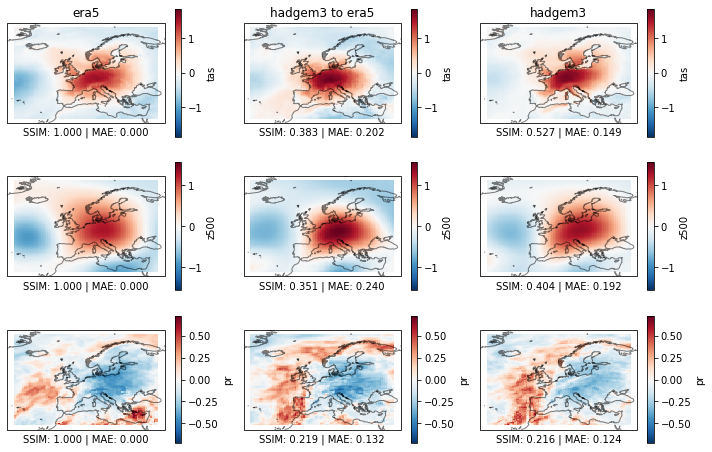

In [101]:
# summer events
compare_events(*v2_h2e_events_300k[0::2], 'era5')
plt.show()

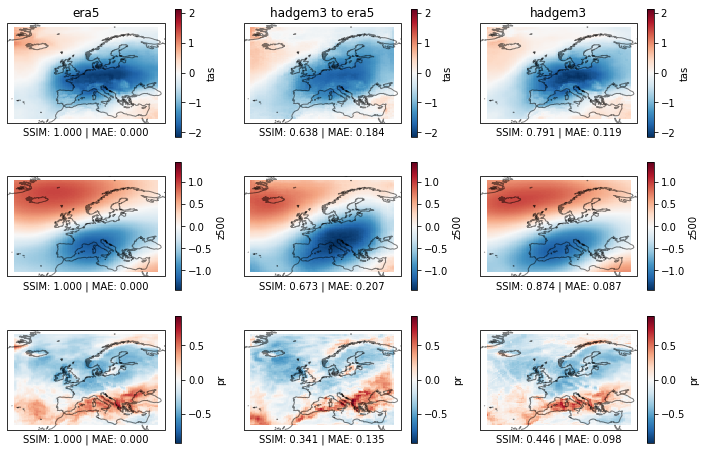

In [102]:
# winter events
compare_events(*v2_h2e_events_300k[1::2], 'era5')
plt.show()